In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import random


2025-11-28 14:44:12.900247: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 14:44:12.917041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764337452.936448   14904 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764337452.942491   14904 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764337452.959609   14904 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
import os

base_path = ""
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
valid_path = os.path.join(base_path, "Validation")

#image classes
image_classes = os.listdir("")
image_classes

['Non Defective', 'Defective']

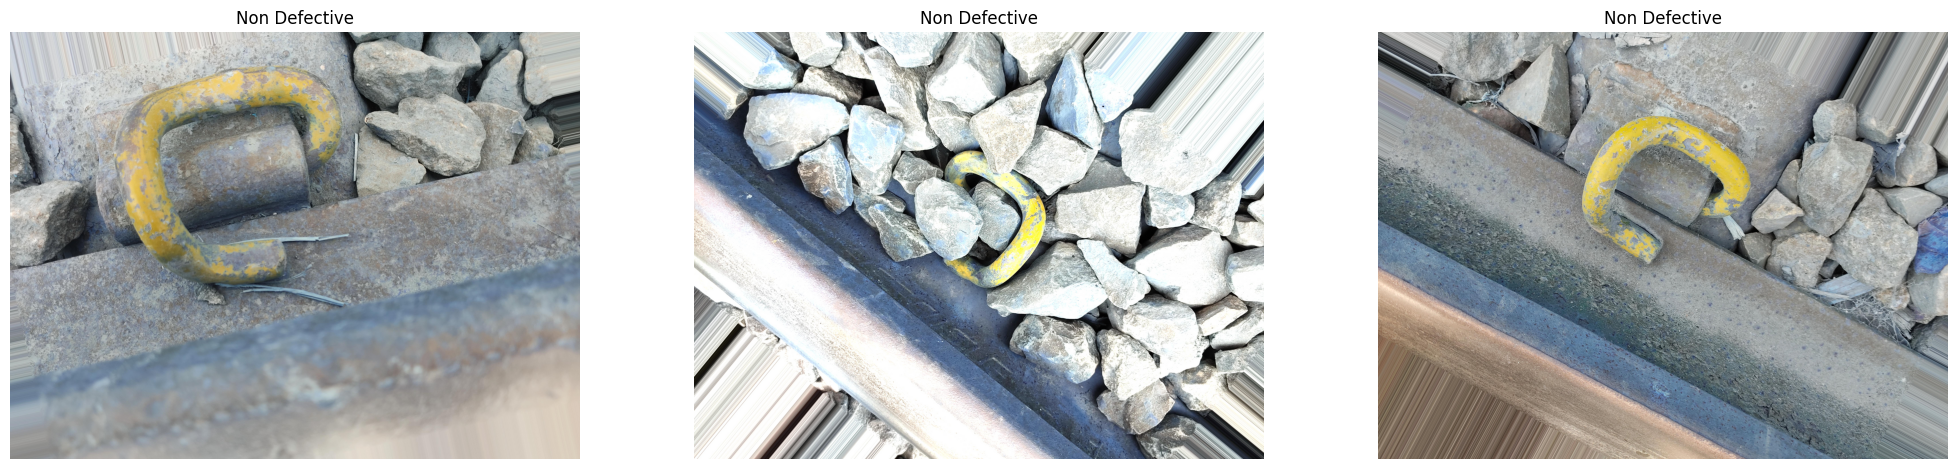

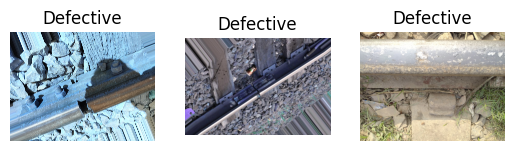

In [3]:
from PIL import Image
def plot_images(image_classes):
    plt.figure(figsize = (25, 25))
    
    for i, category in enumerate(image_classes):
        image_path = train_path + "/" + category
        image_in_folder = os.listdir(image_path)
        
        for j in range(3):
            omage = image_in_folder[j]
            omage_path = image_path + "/" + omage
        
            img = image.load_img(omage_path)
            img_array = image.img_to_array(img) / 255
            
            plt.subplot(3,3, j+1)
            plt.imshow(img_array)
            plt.title(category)
            plt.axis("off")
        plt.show()

plot_images(image_classes)

In [4]:
image_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_data_noaug = image_generator.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = "categorical")

Found 980 images belonging to 2 classes.


In [6]:
test_data = image_generator.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                batch_size = 1,
                                                class_mode = "categorical")

Found 140 images belonging to 2 classes.


In [7]:
valid_data = image_generator.flow_from_directory(valid_path,
                                                target_size = (224, 224),
                                                batch_size = 16,
                                                class_mode = "categorical")

Found 280 images belonging to 2 classes.


In [ ]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)

In [ ]:
from tensorflow.keras.applications import ResNet152V2

def build_ResNet152V2_model():

    model=ResNet152V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
    model.trainable = False
    x = model.output
    # CLASSIFICATION
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='gelu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='gelu')(x)
    y = Dense(2, activation = "softmax")(x)
    return Model(inputs=model.input, outputs=y)

set_seed(42)
model_noaug = build_ResNet152V2_model()

I0000 00:00:1764337460.063502   14904 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
model_noaug.compile(optimizer = "adam", 
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])


In [ ]:
# Define the Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True
)

In [12]:
model_noaug.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 58,890,370 (224.65 MB)

 Trainable params: 558,210 (2.13 MB)

 Non-trainable params: 58,332,160 (222.52 MB)

In [13]:
model_history = model_noaug.fit(train_data_noaug, 
                         epochs = 30,
                         validation_data = valid_data,
                         callbacks = [early_stopping])
model_noaug.save("ResNet152V2_trained_with_Fastener_Only.keras")


/home/jasser/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1764337480.828638   15116 cuda_dnn.cc:529] Loaded cuDNN version 91002


31/31 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6926 - loss: 0.6642 - val_accuracy: 0.8071 - val_loss: 0.4700
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9020 - loss: 0.2643 - val_accuracy: 0.8679 - val_loss: 0.3309
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9421 - loss: 0.1542 - val_accuracy: 0.8821 - val_loss: 0.3217
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9625 - loss: 0.1019 - val_accuracy: 0.8929 - val_loss: 0.2546
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9773 - loss: 0.0723 - val_accuracy: 0.9214 - val_loss: 0.1890
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9771 - loss: 0.0667 - val_accuracy: 0.9286 - val_loss: 0.1994
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9844 - loss: 0.0479 - val_accuracy: 0.9321 - val_loss: 0.2198
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9892 - loss: 0.0396 - val_accuracy: 0.9071 - val_loss: 0.2670
Epo

In [21]:
model_noaug.evaluate(test_data)

140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.9155 - loss: 0.2155


[0.2427768111228943, 0.8999999761581421]

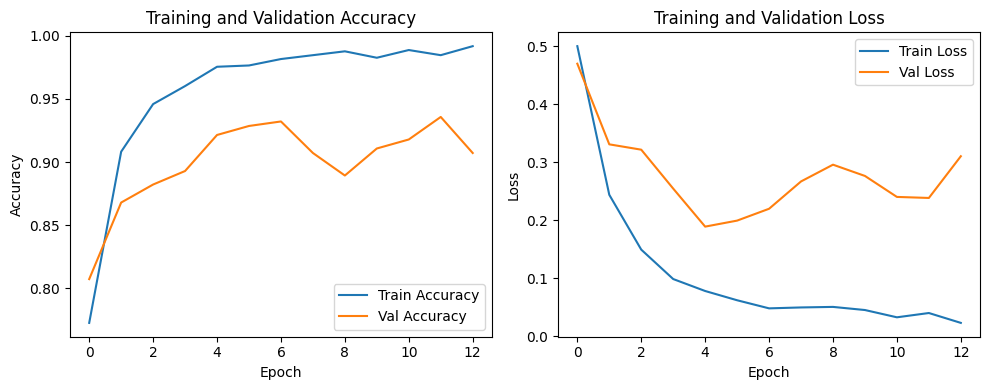

In [15]:
plt.figure(figsize=(10,4))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 140 images belonging to 2 classes.
📊 Classification Report:

               precision    recall  f1-score   support

    Defective       0.88      0.93      0.90        70
Non Defective       0.92      0.87      0.90        70

     accuracy                           0.90       140
    macro avg       0.90      0.90      0.90       140
 weighted avg       0.90      0.90      0.90       140



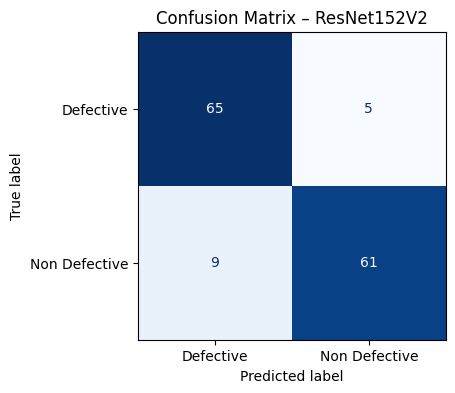

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

test_data = image_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

test_data.reset()

pred_probs = model_noaug.predict(test_data, verbose=0)

y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes

target_names = list(test_data.class_indices.keys())
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names
)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title('Confusion Matrix – ResNet152V2')
plt.show()
